In [706]:
import pandas as pd
import random
import numpy as np
import aif360

seed = 12
bootstrap_train = True
bootstrap_test = False
predicted_variable = 'is_violent_recid' # 'is_recid or is_violent_recid'

np.random.seed(seed)
random.seed(seed)

Load in the relevant data, parsing the date fields to a format pandas understands on the way.

In [707]:

df = pd.read_csv(
    'compas-scores.csv',
    usecols=[
        predicted_variable,
        'sex',
        'age',
        #'age_cat',
        'race',
        'juv_fel_count', 
        #'decile_score',
        'juv_misd_count',
        'juv_other_count', 
        'priors_count',
        'days_b_screening_arrest',
        'c_jail_in',
        'c_jail_out',
        'c_offense_date',
        'c_arrest_date', 
        'c_days_from_compas', 
        'c_charge_degree',
        'c_charge_desc', 
        #'is_recid',
        #'num_r_cases',
        #'r_charge_degree', 
        #'r_days_from_arrest', 
        #'r_offense_date',
        #'r_charge_desc', 
        #'r_jail_in', 
        #'r_jail_out', 
        #'is_violent_recid',
        #'num_vr_cases', 
        #'vr_charge_degree', 
        #'vr_offense_date',
        #'vr_charge_desc', 
        #'v_decile_score',
        #'v_score_text', 
        #'v_screening_date', 
        #'score_text', 
    ],
    parse_dates=[
        'c_jail_in', 
        'c_jail_out', 
        'c_offense_date', 
        'c_arrest_date', 
        #'r_offense_date', 
        #'r_jail_in', 
        #'r_jail_out', 
        #'vr_offense_date',
        #'v_screening_date'
    ]
)

In [708]:
print(df.shape)
df = df[df['c_days_from_compas'] <= 1000]
print(df.shape)
df['c_charge_desc'] = df.c_charge_desc.apply(lambda x: str(x).lower())

(11757, 16)
(10813, 16)


Prune non-violent out from the dataset

In [709]:
v_crimes = pd.read_csv('unique_c_charge_desc_lowercase.csv').query('v == "v"').battery.unique()
df = df[df.c_charge_desc.apply(lambda x: x.lower() in v_crimes)]
#pd.read_csv('unique_c_charge_desc_lowercase.csv').query('v == "v"').to_csv('unique_violent_crimes.csv')
print(df.columns)

Index(['sex', 'age', 'race', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'days_b_screening_arrest',
       'c_jail_in', 'c_jail_out', 'c_offense_date', 'c_arrest_date',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc',
       'is_violent_recid'],
      dtype='object')


Transform all string data to lowercase and remove extra whitespace. This handles some problematic cases where we have e.g. 'Id theft' and 'ID Theft' as separate labels.

In [710]:
df.juv_fel_count = df.juv_fel_count.apply(lambda x: str(x))
df.juv_misd_count = df.juv_fel_count.apply(lambda x: str(x))
df.priors_count = df.priors_count.apply(lambda x: str(x))
df = df.applymap(lambda s : s.lower().strip() if type(s) == str else s)

#df['c_charge_desc'].value_counts().to_csv('cadasdas.csv')

Transform all string columns to groups of binary columns. This is probably not the smartest way to go about this, given that we have so many crime labels. The smart thing to do would probably be some type of a crime classification system, e.g. is_violent, is_with_weapon, etc. But that would require a lot of manual work.

In [711]:
df = pd.get_dummies(df)

Compute jail lengths and divide age into categories

In [712]:
df['c_days_in_jail'] = (df['c_jail_out'] - df['c_jail_in']).dt.days.fillna(0).astype(int)
df['days_in_unknown'] = df.c_days_in_jail.apply(lambda x: 1 if x == 0 else 0)

#df['age_minor'] = df.age.apply(lambda x: 1 if x < 19 else 0) # there are none of these
df['age_19_30'] = df.age.apply(lambda x: 1 if (x >= 19 and x < 30) else 0)
df['age_30_45'] = df.age.apply(lambda x: 1 if (x >= 30 and x < 45) else 0)
df['age_45_65'] = df.age.apply(lambda x: 1 if (x >= 45 and x < 65) else 0)
df['age_old'] = df.age.apply(lambda x: 1 if x > 65 else 0)

df.drop(['age'], axis='columns', inplace=True)

Drop date columns

In [713]:
df.drop([
        'c_jail_in', 
        'c_jail_out', 
        'c_offense_date', 
        'c_arrest_date', 
        'sex_female',
        #'c_days_from_compas',
        #'days_b_screening_arrest'
    ],
    axis='columns',
    inplace=True
)
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(1323, 121)
(1289, 121)


Should be no more NaNs to go, so we can continue to learning.

Split to target and explanatory variables

In [714]:
df_ = df.query(predicted_variable + ' in (0, 1)')
print('negative samples: ', len(df) - len(df_))
X = df_.loc[:, df_.columns != predicted_variable]
y = df_.loc[:, df_.columns == predicted_variable]
print('data shape:', X.shape, y.shape)
n_pos = y[predicted_variable].sum()
print('P(positive) =', n_pos / (y.shape[0]))

negative samples:  0
data shape: (1289, 120) (1289, 1)
P(positive) = 0.10473235065942592


Split to train and test sets

In [715]:
from sklearn import model_selection
#seed=42
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1, random_state=seed)
pos = y_train.sum()
print('train pos rate:', pos / len(y_train))
pos = y_test.sum()
print('test pos rate:', pos / len(y_test))

train pos rate: is_violent_recid    0.099138
dtype: float64
test pos rate: is_violent_recid    0.155039
dtype: float64


In [716]:
from sklearn.utils import resample
from sklearn.utils import shuffle

def even_pos_neg_with_bootsrap(X, y, n_samples=2000):
    print('bootstrap to make more data')

    X_pos = X[y[predicted_variable] == 1]
    X_neg = X[y[predicted_variable] == 0]
    y_pos = y[y[predicted_variable] == 1]
    y_neg = y[y[predicted_variable] == 0]

    X_pos, y_pos = resample(X_pos, y_pos, n_samples=int(n_samples / 2), random_state=seed)
    X_neg, y_neg = resample(X_neg, y_neg, n_samples=int(n_samples / 2), random_state=seed)
    
    return shuffle(X_pos.append(X_neg), y_pos.append(y_neg), random_state=seed)    

In [717]:
if bootstrap_train: X_train, y_train = even_pos_neg_with_bootsrap(X_train, y_train, 2000)
if bootstrap_test: X_test, y_test = even_pos_neg_with_bootsrap(X_test, y_test, 200)
print('train data shape:', X_train.shape, y_train.shape)
n_pos = y_train[predicted_variable].sum()
print('P(positive) train =', n_pos / (y_train.shape[0]))
n_pos = y_test[predicted_variable].sum()
print('P(positive) test =', n_pos / (y_test.shape[0]))


bootstrap to make more data
train data shape: (2000, 120) (2000, 1)
P(positive) train = 0.5
P(positive) test = 0.15503875968992248


In [718]:
from sklearn import linear_model as lm
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.metrics import precision_recall_fscore_support as pr_f1, accuracy_score as acc, matthews_corrcoef, \
roc_auc_score
from time import time
import numpy as np

def init_scores():
    return {'model':[], 'accuracy':[], 'precision':[], 'recall':[], 'f1':[], 'matthew':[], 'rocauc':[]}


def print_score(modelname, y, y_hat):
    accuracy = acc(y, y_hat)
    matt = matthews_corrcoef(y, y_hat)
    p, r, f1, sup = pr_f1(y, y_hat)
    roc_auc = roc_auc_score(y, y_hat)
    print('model', modelname)
    print('acc', acc(y, y_hat))
    print('precision', tuple(p))
    print('recall', tuple(r))
    print('F1', tuple(f1))
    print('matthew', matt)
    print('roc_auc', roc_auc)
    
def save_score(scores, modelname, y, y_hat):
    accuracy = acc(y, y_hat)
    matt = matthews_corrcoef(y, y_hat)
    p, r, f1, sup = pr_f1(y, y_hat)
    roc_auc = roc_auc_score(y, y_hat)
    scores['model'].append(modelname)
    scores['accuracy'].append(acc(y, y_hat))
    scores['precision'].append(p[1])
    scores['recall'].append(r[1])
    scores['f1'].append(f1[1])
    scores['matthew'].append(matt)
    scores['rocauc'].append(roc_auc)

In [719]:
import warnings

def warn(*args, **kwargs):
    pass

old_warn = warnings.warn
warnings.warn = warn

In [720]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


scores = init_scores()

naive_y = np.zeros(len(y_test))
save_score(scores, 'Naive', y_test, naive_y)

print(seed)
def train_and_eval(name, model, rounding=False, scores=scores):
    start = time()
    model.fit(X_train, y_train.values.ravel())
    y_hat = model.predict(X_test)
    if rounding: y_hat = np.round(y_hat)
    save_score(scores, name, y_test, y_hat)
    print('{} trained in {:.3f} seconds'.format(name, time() - start))

models = {'Logreg': lm.LogisticRegression(random_state=seed),
          'Ptron': lm.Perceptron(random_state=seed),
          'KNN': KNeighborsClassifier(),
          'GNB': GaussianNB(),
          'BNB': BernoulliNB(),
          'RF': RandomForestClassifier(random_state=seed),
          'GBT': GradientBoostingClassifier(n_estimators=300, subsample=.5,
                                            random_state=seed),
          'MLP2': MLP(hidden_layer_sizes=((16,)*2), random_state=seed,
                       solver='adam', activation='logistic'),
          'MLP3': MLP(hidden_layer_sizes=((16, 8, 16)), random_state=seed,
                       solver='adam', activation='logistic'),
          'MLP4': MLP(hidden_layer_sizes=((16,)*4), random_state=seed,
                       solver='adam', activation='logistic'),
          'SVCRbf': SVC(random_state=seed)}

for name, model in models.items():
    train_and_eval(name, model)

12
Logreg trained in 0.020 seconds
Ptron trained in 0.013 seconds
KNN trained in 0.041 seconds
GNB trained in 0.006 seconds
BNB trained in 0.006 seconds
RF trained in 0.035 seconds


/u/48/sarsas2/unix/miniconda3/envs/def/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


GBT trained in 1.399 seconds
MLP2 trained in 1.612 seconds
MLP3 trained in 1.900 seconds
MLP4 trained in 0.055 seconds


/u/48/sarsas2/unix/miniconda3/envs/def/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


SVCRbf trained in 0.583 seconds


In [721]:
%matplotlib notebook
from matplotlib import pyplot as plt
scores_df = pd.DataFrame(data=scores)
print(scores_df)
print(scores_df.model.values)
ax = scores_df.plot(kind='line', x='model', y=['accuracy', 'rocauc', 'f1'], xticks=range(len(models) + 1),
                    yticks=np.arange(10) / 10, color=['gray', 'orange', 'green'])
ax.set_xticklabels(list(scores_df.model))
for p in ax.patches:
     ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.02))
ax.axhline(y=0.65, xmin=0.0, xmax=1.0, color='black', linewidth=.1)
ax.axhline(y=0.35, xmin=0.0, xmax=1.0, color='black', linewidth=.1)
plt.tight_layout()
plt.show()

     model  accuracy  precision  recall        f1   matthew    rocauc
0    Naive  0.844961   0.000000    0.00  0.000000  0.000000  0.500000
1   Logreg  0.713178   0.282051    0.55  0.372881  0.231004  0.646560
2    Ptron  0.581395   0.185185    0.50  0.270270  0.070675  0.548165
3      KNN  0.689922   0.187500    0.30  0.230769  0.051513  0.530734
4      GNB  0.271318   0.157407    0.85  0.265625  0.014841  0.507569
5      BNB  0.736434   0.281250    0.45  0.346154  0.200285  0.619495
6       RF  0.775194   0.153846    0.10  0.121212 -0.001103  0.499541
7      GBT  0.790698   0.315789    0.30  0.307692  0.184584  0.590367
8     MLP2  0.751938   0.269231    0.35  0.304348  0.158513  0.587844
9     MLP3  0.767442   0.321429    0.45  0.375000  0.242051  0.637844
10    MLP4  0.844961   0.000000    0.00  0.000000  0.000000  0.500000
11  SVCRbf  0.705426   0.263158    0.50  0.344828  0.193035  0.621560
['Naive' 'Logreg' 'Ptron' 'KNN' 'GNB' 'BNB' 'RF' 'GBT' 'MLP2' 'MLP3'
 'MLP4' 'SVCRbf']


<IPython.core.display.Javascript object>

In [722]:
comb_models = [models[key] for key in ('Logreg', 'MLP3', 'GBT')]
y_hat =  np.sum([ml.predict_proba(X_test)[:,1] for ml in comb_models], axis=0) / len(comb_models)
print_score('Comb', y_test, [np.round(y) for y in y_hat])

model Comb
acc 0.7751937984496124
precision (0.8703703703703703, 0.2857142857142857)
recall (0.8623853211009175, 0.3)
F1 (0.8663594470046083, 0.2926829268292683)
matthew 0.15920382218160828
roc_auc 0.5811926605504587


In [723]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import Callback
from keras.regularizers import l2
np.random.seed(seed)
# create model
nn = Sequential()
nn.add(Dense(16, input_dim=X_train.shape[1], activation='selu'))
nn.add(Dropout(0.5))
nn.add(Dense(8, activation='selu'))
nn.add(Dropout(0.5))
nn.add(Dense(16, activation='selu'))
nn.add(Dropout(0.5))
nn.add(Dense(1, activation='sigmoid', kernel_regularizer=l2()))
# Compile model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model

def evaluate_model():
        y_hat = [np.round(y) for y in nn.predict(X_test)]
        print_score('Keras MLP', y_test, y_hat)


class EvalCallback(Callback):
    def __init__(self, interval=20):
        super(Callback, self).__init__()
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            print('epoch', epoch)
            evaluate_model()

start = time()
nn.fit(X_train, y_train.values.ravel(), epochs=100, batch_size=100, callbacks=[EvalCallback()], verbose=0)
# evaluate the model
print('model trained in {:.2f} second'.format(time() - start))
print_score('Keras MLP', y_test, nn.predict_classes(X_test))

epoch 19
model Keras MLP
acc 0.5891472868217055
precision (0.8888888888888888, 0.21052631578947367)
recall (0.5871559633027523, 0.6)
F1 (0.707182320441989, 0.3116883116883116)
matthew 0.1364043562299945
roc_auc 0.5935779816513762
epoch 39
model Keras MLP
acc 0.6356589147286822
precision (0.8875, 0.22448979591836735)
recall (0.6513761467889908, 0.55)
F1 (0.7513227513227513, 0.3188405797101449)
matthew 0.15017347829003053
roc_auc 0.6006880733944954
epoch 59
model Keras MLP
acc 0.6356589147286822
precision (0.8875, 0.22448979591836735)
recall (0.6513761467889908, 0.55)
F1 (0.7513227513227513, 0.3188405797101449)
matthew 0.15017347829003053
roc_auc 0.6006880733944954
epoch 79
model Keras MLP
acc 0.6356589147286822
precision (0.8780487804878049, 0.2127659574468085)
recall (0.6605504587155964, 0.5)
F1 (0.7539267015706806, 0.2985074626865672)
matthew 0.12074911110869035
roc_auc 0.5802752293577982
epoch 99
model Keras MLP
acc 0.6434108527131783
precision (0.8795180722891566, 0.2173913043478260

In [733]:
lr = models['Logreg']
mlp = models['MLP3']

lr.fit(X_train, y_train.values)
print_score('Logreg', y_test, lr.predict(X_test))
lr_orig_coefs = lr.coef_[0].copy()
mlp.fit(X_train, y_train.values)
mlp_orig_coefs = mlp.coefs_[0].copy()
print_score('MLP2', y_test, mlp.predict(X_test))

model Logreg
acc 0.7131782945736435
precision (0.9, 0.28205128205128205)
recall (0.7431192660550459, 0.55)
F1 (0.8140703517587939, 0.3728813559322034)
matthew 0.23100376226211541
roc_auc 0.646559633027523
model MLP2
acc 0.7674418604651163
precision (0.8910891089108911, 0.32142857142857145)
recall (0.8256880733944955, 0.45)
F1 (0.8571428571428572, 0.375)
matthew 0.24205080015371494
roc_auc 0.6378440366972477


In [734]:

def sensitive_col(x):
    if any (s in x and 'c_charge' not in x for s in ('race', 'age', 'sex')): return True
    return False

sens_coeffs = [(i, coef, col) for i, col, coef in zip(range(len(X.columns)), X.columns, lr_orig_coefs)
               if sensitive_col(col)]
print(*sens_coeffs, sep='\n')
def neutralized_sensitive_coef(coef, col):
    return 0 if sensitive_col(col) else coef

def neutralized_sensitive_coefs(coef, col):
    return np.zeros(len(coef)) if sensitive_col(col) else coef

mlp.coefs_[0] = [neutralized_sensitive_coefs(coef, col) for col, coef in zip(X.columns, mlp_orig_coefs)]
lr.coef_[0] = [neutralized_sensitive_coef(coef, col) for col, coef in zip(X.columns, lr_orig_coefs)]
sens_coeffs = [(i, coef, col) for i, col, coef in zip(range(len(X.columns)), X.columns, lr.coef_[0])
               if sensitive_col(col)]
print(*sens_coeffs, sep='\n')

#print_score('\nnon-discriminate logreg ', y_test, lr.predict(X_test))
#lr.coef_[0] = orig_coefs
#print_score('\ndiscriminate logreg ', y_test, lr.predict(X_test))


(3, 0.658979304262008, 'sex_male')
(4, -0.06061837804628509, 'race_african-american')
(5, -0.8926866801570499, 'race_asian')
(6, -0.6395567530496021, 'race_caucasian')
(7, -0.0922436625059309, 'race_hispanic')
(8, 1.1584722475628073, 'race_native american')
(9, 0.37575954180853666, 'race_other')
(116, 0.4212836680771746, 'age_19_30')
(117, -0.39314659451991235, 'age_30_45')
(118, -0.47113230652081883, 'age_45_65')
(119, 0.6628524345726942, 'age_old')
(3, 0.0, 'sex_male')
(4, 0.0, 'race_african-american')
(5, 0.0, 'race_asian')
(6, 0.0, 'race_caucasian')
(7, 0.0, 'race_hispanic')
(8, 0.0, 'race_native american')
(9, 0.0, 'race_other')
(116, 0.0, 'age_19_30')
(117, 0.0, 'age_30_45')
(118, 0.0, 'age_45_65')
(119, 0.0, 'age_old')


That's... not horrible. Let's check which features have the greatest effect on the thing. 

In [726]:
coeffs = [(coef, col) for col, coef in zip(X.columns, lr.coef_[0])]
#coefs = gbt.feature_importances_
import numpy as np
#coefs = [np.mean(c) for c in nn.coef_[0]]
#coeffs = [(coef, col) for col, coef in zip(X.columns, coefs)] # for neural net / gbt
#coeffs = sorted(coeffs, reverse=True)
#for a, b in sorted(coeffs): print(a, b)


In [727]:
#coeffs = [(coef, col) for col, coef in zip(X.columns, model.coef_[0])]
#coeffs = sorted(coeffs, reverse=True)
#for a, b in coeffs[:20]: print(a, b)
#print('...')
orig = {col:coef for coef, col in coeffs}
abss = sorted([(abs(coef), col) for coef, col in coeffs], key=lambda x: x[0])
near_zero = sorted([(orig[col], col) for coef, col in abss[:50]], reverse=True)
#for a, b in near_zero: print(a, b)
#print('...')
#for a, b in coeffs[-20:]: print(a, b)

Let's check the non-crime label ones specifically

In [728]:
#for a, b in coeffs: print(a, b) if 'charge_desc' not in b else ...
    
A = [(b, a) for a, b in coeffs if 'charge_desc' not in b]
A_ = sorted(A, key=lambda x: -x[1])

for a, b in A_:
    print(a, '{:.3}'.format(b))

priors_count_18 1.39
priors_count_38 1.38
priors_count_7 1.28
priors_count_6 0.953
priors_count_20 0.935
priors_count_14 0.841
priors_count_13 0.752
juv_fel_count_8 0.693
juv_misd_count_8 0.693
priors_count_4 0.669
priors_count_12 0.63
priors_count_9 0.603
priors_count_10 0.507
priors_count_8 0.364
priors_count_5 0.317
c_charge_degree_f 0.29
juv_fel_count_1 0.173
juv_misd_count_1 0.173
juv_other_count 0.0231
days_b_screening_arrest 0.00264
sex_male 0.0
race_african-american 0.0
race_asian 0.0
race_caucasian 0.0
race_hispanic 0.0
race_native american 0.0
race_other 0.0
priors_count_23 0.0
priors_count_29 0.0
age_19_30 0.0
age_30_45 0.0
age_45_65 0.0
age_old 0.0
c_days_in_jail -0.00024
c_days_from_compas -0.00356
days_in_unknown -0.0176
priors_count_16 -0.0362
juv_fel_count_2 -0.148
juv_misd_count_2 -0.148
juv_fel_count_0 -0.19
juv_misd_count_0 -0.19
priors_count_1 -0.239
priors_count_24 -0.305
priors_count_33 -0.328
priors_count_22 -0.368
priors_count_2 -0.373
priors_count_15 -0.402
c_c

Try linear support vector regression next

Marginally better, still pretty bad. Let's try support vector regression with an RBF. In principle it has an infinite-dimensional faeture space so that should get to something reasonable at the cost of possibly overfitting.

In [764]:
all_sens_vars = {sensitive_col(x) for x in X.columns}

def pythonify_col(x):
    return x.translate(str.maketrans(' -().+,></', '__________'))

def measure_discrimination(model, df, sens_var):
    """
    Measure discrimination
    """
    X = df.copy()
    X.columns = pythonify_col(df.columns.str)  
    sens_var = pythonify_col(sens_var)
    
    n_pos_sens = len(X.query('{}==1'.format(sens_var)))
    if n_pos_sens == 0 or n_pos_sens == len(X): return
    
    a = np.mean(model.predict(X.query('{}==1'.format(sens_var))))
    b = np.mean(model.predict(X.query('{}==0'.format(sens_var))))
    print('{}: {:.3f}'.format(sens_var, abs(a - b)))

    """
    Calculate explained difference
    """
    d_expl = 0
    for e in X.columns.difference((sens_var,)).difference(all_sens_vars):
        fixed = X[e].mode()[0]
        fixed = 1
        if X[e].max() > 1: continue 
        #print(e, 'mode:', fixed)
        e1 = X.query('{}==1'.format(sens_var))[e].mean()
        e0 = X.query('{}==0'.format(sens_var))[e].mean()
        p1X = X.query('{}==1 and {}=={}'.format(sens_var, e, fixed))
        p0X = X.query('{}==0 and {}=={}'.format(sens_var, e, fixed))
        d_expl += (e1 - e0) * sum([np.mean(model.predict(x)) for x in (p1X, p0X) if len(x) > 0]) / 2
    print('{} expl: {:.3f}'.format(sens_var, d_expl))

sens_vars = [x for x in X_train.columns if sensitive_col(x)]
print(sens_vars)


['sex_male', 'race_african-american', 'race_asian', 'race_caucasian', 'race_hispanic', 'race_native american', 'race_other', 'age_19_30', 'age_30_45', 'age_45_65', 'age_old']


In [765]:
mod_scores = init_scores()
print('discrimination for logreg modified')
lr.coef_[0] = [neutralized_sensitive_coef(coef, col) for col, coef in zip(X.columns, lr_orig_coefs)]
save_score(mod_scores, 'lr_mod', y_test, lr.predict(X_test))
for sens_var in sens_vars:
    measure_discrimination(lr, X_test, sens_var)
print('\ndiscrimination logreg unmodified')
lr.coef_[0] = lr_orig_coefs
save_score(mod_scores, 'lr', y_test, lr.predict(X_test))
for sens_var in sens_vars:
    measure_discrimination(lr, X_test, sens_var)

discrimination for logreg modified
sex_male: 0.013
sex_male expl: -0.012
race_african_american: 0.061
race_african_american expl: 0.065
race_asian: 0.130
race_asian expl: 0.248
race_caucasian: 0.046
race_caucasian expl: -0.116
race_hispanic: 0.147
race_hispanic expl: -0.281
race_other: 0.229
race_other expl: -0.240
age_19_30: 0.140
age_19_30 expl: -0.152
age_30_45: 0.114
age_30_45 expl: 0.001
age_45_65: 0.016
age_45_65 expl: -0.038

discrimination logreg unmodified
sex_male: 0.194
sex_male expl: 0.010
race_african_american: 0.159
race_african_american expl: 0.084
race_asian: 0.142
race_asian expl: -0.086
race_caucasian: 0.132
race_caucasian expl: -0.316
race_hispanic: 0.251
race_hispanic expl: -0.305
race_other: 0.266
race_other expl: 0.044
age_19_30: 0.244
age_19_30 expl: -0.021
age_30_45: 0.089
age_30_45 expl: -0.109
age_45_65: 0.195
age_45_65 expl: -0.243


In [766]:
print('discrimination for mlp modified')
mlp.coefs_[0] = [neutralized_sensitive_coefs(coef, col) for col, coef in zip(X.columns, mlp_orig_coefs)]
save_score(mod_scores, 'mlp3_mod', y_test, mlp.predict(X_test))
for sens_var in sens_vars:
    measure_discrimination(mlp, X_test, sens_var)
print('\ndiscrimination mlp unmodified')
mlp.coefs_[0] = mlp_orig_coefs
save_score(mod_scores, 'mlp3', y_test, mlp.predict(X_test))
for sens_var in sens_vars:
    measure_discrimination(mlp, X_test, sens_var)
    

discrimination for mlp modified
sex_male: 0.092
sex_male expl: 0.032
race_african_american: 0.149
race_african_american expl: 0.096
race_asian: 0.069
race_asian expl: -0.036
race_caucasian: 0.089
race_caucasian expl: -0.132
race_hispanic: 0.112
race_hispanic expl: -0.092
race_other: 0.110
race_other expl: -0.079
age_19_30: 0.012
age_19_30 expl: -0.029
age_30_45: 0.095
age_30_45 expl: 0.056
age_45_65: 0.127
age_45_65 expl: -0.152

discrimination mlp unmodified
sex_male: 0.289
sex_male expl: 0.057
race_african_american: 0.240
race_african_american expl: 0.174
race_asian: 0.053
race_asian expl: -0.118
race_caucasian: 0.135
race_caucasian expl: -0.297
race_hispanic: 0.241
race_hispanic expl: -0.206
race_other: 0.039
race_other expl: -0.029
age_19_30: 0.198
age_19_30 expl: -0.004
age_30_45: 0.006
age_30_45 expl: 0.000
age_45_65: 0.275
age_45_65 expl: -0.272


      model  accuracy  precision  recall        f1   matthew    rocauc
0    lr_mod  0.728682   0.222222    0.30  0.255319  0.095500  0.553670
1        lr  0.713178   0.282051    0.55  0.372881  0.231004  0.646560
2  mlp3_mod  0.790698   0.230769    0.15  0.181818  0.070045  0.529128
3      mlp3  0.767442   0.321429    0.45  0.375000  0.242051  0.637844


<IPython.core.display.Javascript object>


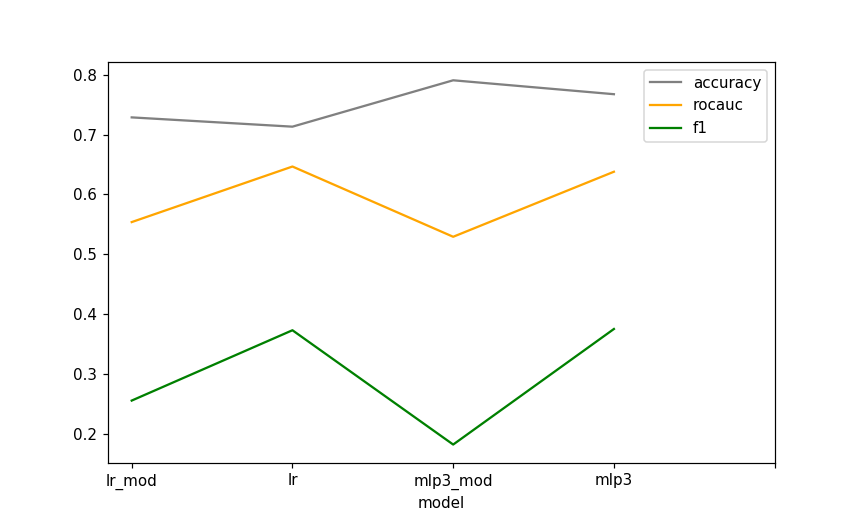

In [767]:
from matplotlib import pyplot as plt
mod_scores_df = pd.DataFrame(data=mod_scores)
print(mod_scores_df)
ax = mod_scores_df.plot(kind='line', x='model', y=['accuracy', 'rocauc', 'f1'], xticks=range(5),
                                        color=['gray', 'orange' ,'green'])
ax.set_xticklabels(list(mod_scores_df.model))

plt.show()

In [768]:
"""
aif360 magic from https://nbviewer.jupyter.org/github/IBM/AIF360/blob/master/examples/tutorial_credit_scoring.ipynb
and https://nbviewer.jupyter.org/github/IBM/AIF360/blob/master/examples/tutorial_gender_classification.ipynb)
"""
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric

from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_german
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_german

sens_var = ['sex_male', 'race_african-american', 'age_19_30']

def dataset_wrapper(outcome, protected, unprivileged_groups, privileged_groups,
                          favorable_label, unfavorable_label):
    """ A wraper function to create aif360 dataset from outcome and protected in numpy array format.
    """
    df = pd.DataFrame(data=outcome,
                      columns=['outcome'])
    for i in range(protected.shape[1]):
        df[sens_var[i]] = protected[:,1]

    dataset = BinaryLabelDataset(favorable_label=favorable_label,
                                       unfavorable_label=unfavorable_label,
                                       df=df,
                                       label_names=['outcome'],
                                       protected_attribute_names=sens_var,
                                       unprivileged_protected_attributes=unprivileged_groups)
    return dataset


from IPython.display import Markdown, display

privileged_groups = [{x: 0 for x in sens_var}]
unprivileged_groups = [{x: 1 for x in sens_var}]


In [769]:
p_train = X_train[sens_var].values
p_test = X_test[sens_var].values
print(p_train.shape)
favorable_label = 0
unfavorable_label = 1
#print(y_test)

(2000, 3)


In [770]:
def dataset_wrapper_wrapper(outcome, protected):
    return dataset_wrapper(outcome=outcome, protected=protected, 
                                                 unprivileged_groups=unprivileged_groups, 
                                                 privileged_groups=privileged_groups,
                                                 favorable_label=favorable_label,
                                          unfavorable_label=unfavorable_label)

original_train_dataset = dataset_wrapper_wrapper(y_train.values, p_train)
original_test_dataset = dataset_wrapper_wrapper(y_test.values, p_test)

mlp.coefs_[0] = mlp_orig_coefs
mlp_predictions_dataset = dataset_wrapper_wrapper(mlp.predict(X_test), p_test)

mlp.coefs_[0] = [neutralized_sensitive_coefs(coef, col) for col, coef in zip(X.columns, mlp_orig_coefs)]
mlp_modified_predictions_dataset = dataset_wrapper_wrapper(mlp.predict(X_test), p_test)

lr.coef_[0] = lr_orig_coefs
lr_predictions_dataset = dataset_wrapper_wrapper(lr.predict(X_test), p_test)

lr.coef_[0] = [neutralized_sensitive_coef(coef, col) for col, coef in zip(X.columns, lr_orig_coefs)]
lr_modified_predictions_dataset = dataset_wrapper_wrapper(lr.predict(X_test), p_test)


In [771]:
metric_original_train = BinaryLabelDatasetMetric(original_train_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_original_train.mean_difference())


#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.097579


In [772]:
from aif360.metrics import ClassificationMetric

def aif360_metrics(test_dataset, pred_dataset, msg):

    classified_metric_nodebiasing_test = ClassificationMetric(test_dataset, 
                                                     pred_dataset,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

    TPR = classified_metric_nodebiasing_test.true_positive_rate()
    TNR = classified_metric_nodebiasing_test.true_negative_rate()
    PPV = classified_metric_nodebiasing_test.positive_predictive_value()
    NPV = classified_metric_nodebiasing_test.negative_predictive_value()
    bal_acc_nodebiasing_test = 0.5*(TPR+TNR)


    f1 = 2 * PPV * TPR / (PPV + TPR)
    f1_ = 2 * NPV * TNR / (NPV + TNR)
    display(msg)
    print("Test set: Classification accuracy = %f" %
          classified_metric_nodebiasing_test.accuracy())
    print("Test set: Balanced classification accuracy = %f" %
          bal_acc_nodebiasing_test)
    print("Test set: F1 score = %f" % f1_)
    print("Test set: Statistical parity difference = %f" %
          classified_metric_nodebiasing_test.statistical_parity_difference())
    print("Test set: Disparate impact = %f" %
          classified_metric_nodebiasing_test.disparate_impact())
    print("Test set: Equal opportunity difference = %f" % 
          classified_metric_nodebiasing_test.equal_opportunity_difference())
    print("Test set: Average odds difference = %f" %
          classified_metric_nodebiasing_test.average_odds_difference())
    print("Test set: Theil index = %f" %
          classified_metric_nodebiasing_test.theil_index())
    print("Test set: False negative rate difference = %f" %
          classified_metric_nodebiasing_test.false_negative_rate_difference())

In [773]:
aif360_metrics(original_test_dataset, mlp_predictions_dataset, 
               Markdown("#### MLP - unmodified - classification metrics"))

#### MLP - unmodified - classification metrics

Test set: Classification accuracy = 0.767442
Test set: Balanced classification accuracy = 0.637844
Test set: F1 score = 0.375000
Test set: Statistical parity difference = -0.240070
Test set: Disparate impact = 0.727682
Test set: Equal opportunity difference = -0.258706
Test set: Average odds difference = -0.134404
Test set: Theil index = 0.190049
Test set: False negative rate difference = 0.258706


In [774]:
aif360_metrics(original_test_dataset, mlp_modified_predictions_dataset, 
               Markdown("#### MLP - modified - classification metrics"))

#### MLP - modified - classification metrics

Test set: Classification accuracy = 0.790698
Test set: Balanced classification accuracy = 0.529128
Test set: F1 score = 0.181818
Test set: Statistical parity difference = -0.149206
Test set: Disparate impact = 0.844663
Test set: Equal opportunity difference = -0.121891
Test set: Average odds difference = -0.197309
Test set: Theil index = 0.120444
Test set: False negative rate difference = 0.121891


In [775]:
aif360_metrics(original_test_dataset, lr_predictions_dataset, 
               Markdown("#### Log reg - unmodified - classification metrics"))

#### Log reg - unmodified - classification metrics

Test set: Classification accuracy = 0.713178
Test set: Balanced classification accuracy = 0.646560
Test set: F1 score = 0.372881
Test set: Statistical parity difference = -0.159384
Test set: Disparate impact = 0.791152
Test set: Equal opportunity difference = -0.124378
Test set: Average odds difference = -0.158149
Test set: Theil index = 0.272756
Test set: False negative rate difference = 0.124378


In [776]:
aif360_metrics(original_test_dataset, lr_modified_predictions_dataset, 
               Markdown("#### Log reg - modified - classification metrics"))

#### Log reg - modified - classification metrics

Test set: Classification accuracy = 0.728682
Test set: Balanced classification accuracy = 0.553670
Test set: F1 score = 0.255319
Test set: Statistical parity difference = -0.061072
Test set: Disparate impact = 0.925137
Test set: Equal opportunity difference = 0.003554
Test set: Average odds difference = -0.169940
Test set: Theil index = 0.214874
Test set: False negative rate difference = -0.003554


In [777]:

from aif360.algorithms.preprocessing.reweighing import Reweighing

RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(original_train_dataset)
transf_train_dataset = RW.transform(original_train_dataset)



In [778]:
metric_orig_train = BinaryLabelDatasetMetric(original_train_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
metric_tranf_train = BinaryLabelDatasetMetric(transf_train_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)


In [779]:


metric_orig_test = BinaryLabelDatasetMetric(original_test_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
transf_test_dataset = RW.transform(original_test_dataset)
metric_transf_test = BinaryLabelDatasetMetric(transf_test_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original testing dataset"))
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_orig_test.mean_difference())
display(Markdown("#### Transformed testing dataset"))
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_transf_test.mean_difference())



#### Original testing dataset

Difference in mean outcomes between privileged and unprivileged groups = -0.089126


#### Transformed testing dataset

Difference in mean outcomes between privileged and unprivileged groups = -0.037126
